In [12]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

from fcutils.maths.signals import get_onset_offset

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\APA_setup")


from electrophysiology.utils import load_rec_data, get_locomotion_onset_times

cache = Path(r"J:\APA")

tracking_files = cache.glob("*.parquet")
recordings = [f.stem for f in tracking_files]
recordings

[
    'FC_210715_AAA1110750_r5_hairpin',
    'FC_210716_AAA1110750_r6_hairpin',
    'FC_210720_AAA1110750_hairpin',
    'FC_210721_AAA1110750_hairpin',
    'FC_210722_AAA1110750_hairpin',
    'FC_210820_BAA1110281_hairpin',
    'FC_210829_BAA1110281_hairpin',
    'FC_210830_BAA1110281_hairpin',
    'FC_210831_BAA1110281_hairpin',
    'FC_210901_BAA1110281_hairpin',
    'FC_210906_BAA1110281_hairpin',
    'FC_210917_BAA1110279_hairpin',
    'FC_210917_BAA1110281_hairpin',
    'FC_211022_BAA110516_hairpin',
    'FC_211027_BAA110516_hairpin',
    'FC_211214_BAA110517_hairpin',
    'FC_220114_BAA110517_hairpin',
    'FC_220117_BAA110517_hairpin',
    'FC_220119_BAA110517_hairpin',
    'FC_220120_BAA110517_hairpin'
]

## Get for each recordings all the time the mouse goes from stationary to moving

In [13]:
tracking, units = load_rec_data(recordings[-6])

In [14]:
right_fl_onsets = get_locomotion_onset_times(tracking, "right_fl")
left_fl_onsets = get_locomotion_onset_times(tracking, "left_fl")

print(f"Number of onsets: {len(right_fl_onsets)} right - {len(left_fl_onsets)} left")

Number of onsets: 41 right - 52 left


<Figure size 864x720 with 1 Axes>

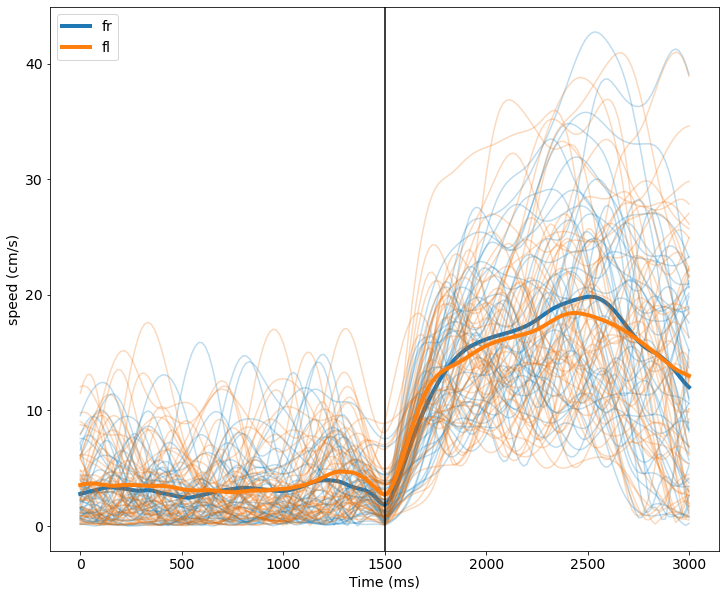

In [15]:
# set font size
plt.rcParams.update({"font.size": 14})

f, ax = plt.subplots(1, 1, figsize=(12, 10))

from analysis.fixtures import dark_colors

for paw, timepoints, sign in zip(("fr", "fl"), (right_fl_onsets, left_fl_onsets), (1, 1)):
    traces = []
    for i, frame in enumerate(timepoints):
        trace = sign * tracking.v[frame-1500:frame+1500].values
        traces.append(trace)
        ax.plot(trace, color = dark_colors[paw], alpha=.25)
    ax.plot(np.mean(traces, axis=0), label=paw, lw=4)


ax.legend()
ax.axvline(1500, color="k")
_ = ax.set(xlabel="Time (ms)", ylabel="speed (cm/s)")

<Figure size 2160x1296 with 24 Axes>

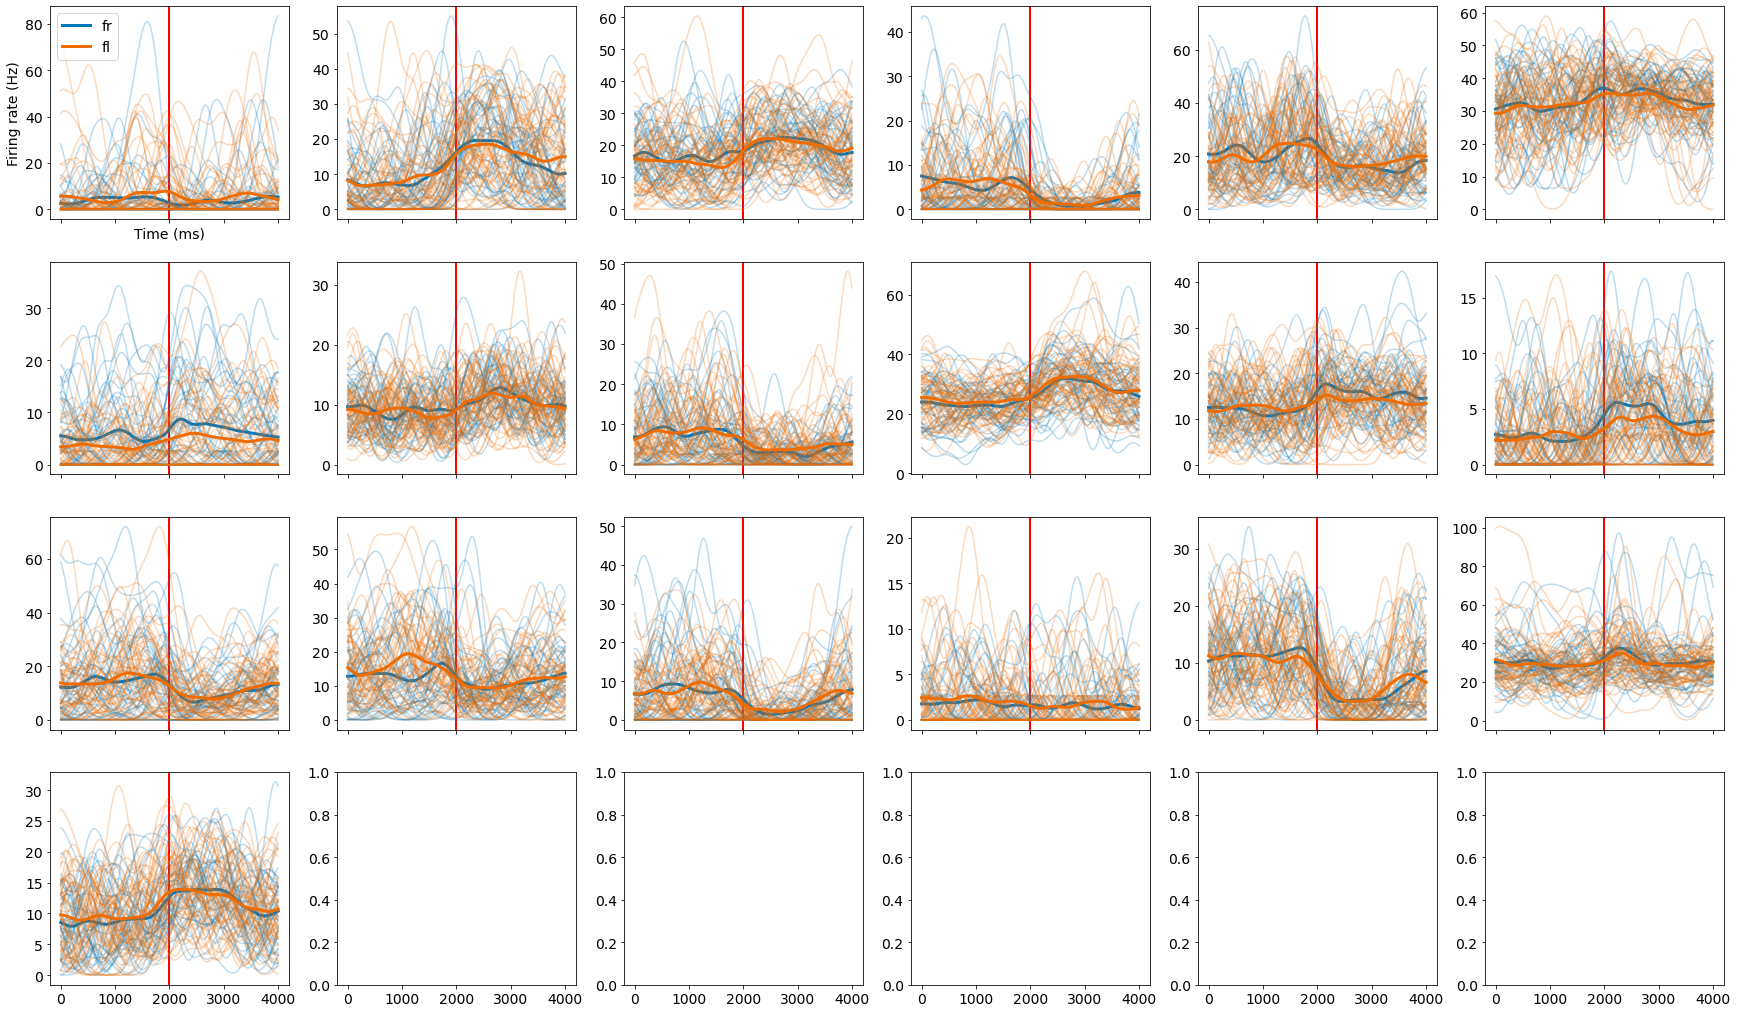

In [16]:
from fcutils.plot.figure import calc_nrows_ncols

figsize = (30, 18)
units_names = units.columns
nrows, ncols = calc_nrows_ncols(len(units_names), aspect=(24, 18))
f, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=False)
axes = axes.flatten()


for i, (name, ax) in enumerate(zip(units_names, axes)):
    ax.axvline(2000, lw=2, color="r")
    for paw, timepoints, sign in zip(("fr", "fl"), (right_fl_onsets, left_fl_onsets), (1, 1)):

        traces = []
        for frame in timepoints:
            trace = sign * units[name].values[frame-2000:frame+2000]
            if len(trace) < 4000:
                continue
            traces.append(trace)
            ax.plot(trace, color = dark_colors[paw], alpha=.25)
        ax.plot(np.mean(traces, axis=0), color=dark_colors[paw], lw=3, label=paw if i == 0 else None)

axes[0].legend()
_ = axes[0].set(xlabel="Time (ms)", ylabel="Firing rate (Hz)")